## MultiLayer Perceptron for FashionMNIST Dataset using Pytorch-ignite
* Pytorch Model Development Pipeline
    * Loading Dataset
    * Building DataLoader
    * Build Model Architecture
    * Prepare Training/Optimization Loop
    * Model Training and Evaluation
    * Model Saving
    * Model Inferencing
    * Model Quantization and Conversion

In [40]:
# !pip install pytorch-ignite

In [41]:
# !pip install torch torchvision

In [42]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet18
from torchvision.transforms import ToTensor, Lambda, Compose, Normalize
import matplotlib.pyplot as plt
from tqdm import tqdm

from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading the Dataset

In [44]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = transform
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = transform
)

## Label Mapping and Visualizing the Dataset

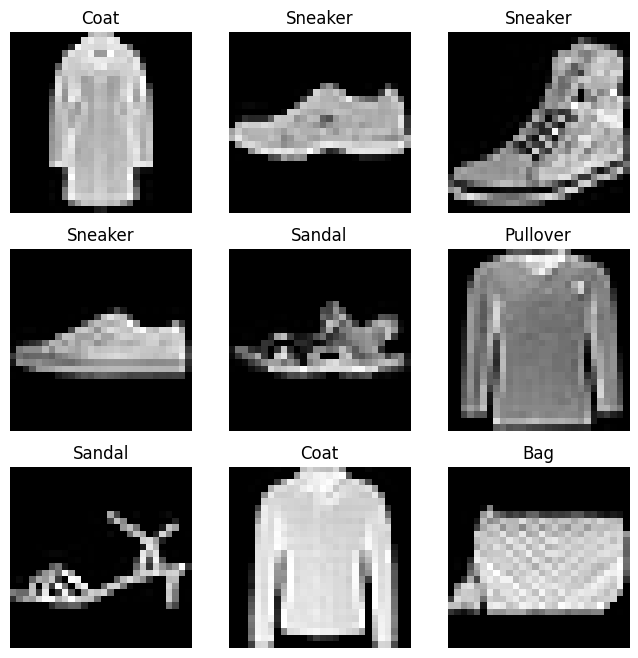

In [45]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Buiding a Dataloader

In [46]:
train_loader = DataLoader(training_data, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 64, shuffle = False)

## Defining the MLP model

In [47]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

## Prepare Training/Optimization Loop


In [48]:
input_size = 28 * 28
hidden_size = 500
num_classes = 10
learning_rate = 0.001

model = MLP(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

## Model Training and Evaluation Engines


In [49]:
def train_step(engine, batch):
  model.train()
  optimizer.zero_grad()
  x, y = batch
  x = x.view(x.size(0), -1)
  y_pred = model(x)
  loss = criterion(y_pred, y)
  loss.backward()
  optimizer.step()
  return loss.item()

def eval_step(engine, batch):
  model.eval()
  with torch.no_grad():
    x, y = batch
    x = x.view(x.size(0), -1)
    y_pred = model(x)
    return y_pred, y

trainer = Engine(train_step)
evaluator = Engine(eval_step)

In [50]:
Accuracy().attach(evaluator, "accuracy")
Loss(criterion).attach(evaluator, "loss")

In [51]:
# Progress bar
ProgressBar().attach(trainer)

# Model checkpoint
checkpointer = ModelCheckpoint('models', n_saved=2, create_dir=True, require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=5), checkpointer, {'model': model})

# Early stopping
def score_function(engine):
    return engine.state.metrics['accuracy']

early_stopping = EarlyStopping(patience=5, score_function=score_function, trainer=trainer)
evaluator.add_event_handler(Events.COMPLETED, early_stopping)


In [52]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    print(f"Training Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(test_loader)
    metrics = evaluator.state.metrics
    print(f"Validation Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")

In [55]:
trainer.run(train_loader, max_epochs=10)

Training Results - Epoch: 7  Avg accuracy: 0.91 Avg loss: 0.24
Validation Results - Epoch: 7  Avg accuracy: 0.88 Avg loss: 0.34


[1/938]   0%|           [00:00<?]

Training Results - Epoch: 8  Avg accuracy: 0.91 Avg loss: 0.24
Validation Results - Epoch: 8  Avg accuracy: 0.88 Avg loss: 0.36


[1/938]   0%|           [00:00<?]

Training Results - Epoch: 9  Avg accuracy: 0.92 Avg loss: 0.21
Validation Results - Epoch: 9  Avg accuracy: 0.88 Avg loss: 0.34


[1/938]   0%|           [00:00<?]

Training Results - Epoch: 10  Avg accuracy: 0.92 Avg loss: 0.20
Validation Results - Epoch: 10  Avg accuracy: 0.89 Avg loss: 0.34


State:
	iteration: 8442
	epoch: 10
	epoch_length: 938
	max_epochs: 10
	output: 0.34351876378059387
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

The model is already being saved using the `ModelCheckpoint` handler during training.

## Model Inferencing
Performing inference on one test sample and comparing the prediction with the actual label.

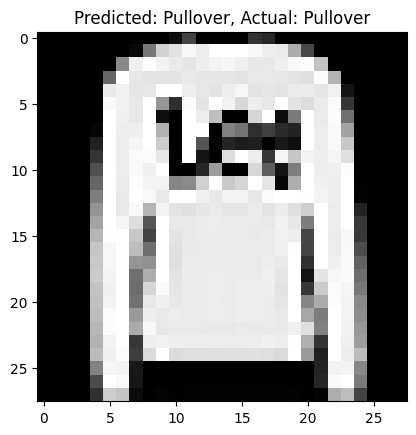

In [60]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

image = images[1].view(1, 28 * 28)
label = labels[1].item()

model.eval()
with torch.no_grad():
  output = model(image)
  _, predicted = torch.max(output, 1)

plt.imshow(images[1].numpy().squeeze(), cmap='gray')
plt.title(f"Predicted: {labels_map[predicted.item()]}, Actual: {labels_map[label]}")
plt.show()

## Model Quantization and Conversion


In [61]:
model.eval()

model_fused = torch.quantization.fuse_modules(model, [['fc1', 'relu'], ['fc2', 'relu2']])

model_prepared = torch.quantization.prepare(model_fused)

for images, _ in train_loader:
  images = images.view(images.size(0), -1)
  model_prepared(images)

model_quantized = torch.quantization.convert(model_prepared)

torch.save(model_quantized.state_dict(), 'quantized_model.pth')

print("Quantized model saved.")

/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/quantize.py:312: UserWarning: None of the submodule got qconfig applied. Make sure you passed correct configuration through `qconfig_dict` or by assigning the `.qconfig` attribute directly on submodules
  warnings.warn("None of the submodule got qconfig applied. Make sure you "


Quantized model saved.
